In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector, Operator, partial_trace
import matplotlib.pyplot as plt
from itertools import combinations

# $2 \times 2$ Sudoku

We begin by considering a simplified instance of the Sudoku puzzle consisting of a $2 \times 2$ grid:

$$
\left[\begin{array}{c|c}
a & b \\
\hline
c & d \\
\end{array}\right], 
\quad \{a, b, c, d\} \in \{0, 1\}.
$$

A configuration of this puzzle constitutes a valid solution if the following constraints are satisfied:

$$
a \neq b, \quad a \neq c, \quad b \neq d, \quad c \neq d.
$$

Under these conditions, there exist exactly two valid solutions:

$$
\left[\begin{array}{c|c}
0 & 1 \\
\hline
1 & 0 \\
\end{array}\right],
\quad
\left[\begin{array}{c|c}
1 & 0 \\
\hline
0 & 1 \\
\end{array}\right].
$$

Each configuration can be uniquely encoded as the binary representation of an integer between \(0\) and \(15\), defined by the tuple $(a\,b\,c\,d)_2$. Accordingly, the two valid solutions correspond to the binary states

$$
6 = (0110)_2, \quad 9 = (1001)_2.
$$

Grover’s search algorithm may be employed to identify these solutions through the following procedure:

1. **Initialization:** Prepare a register of four qubits in the uniform superposition state  

   $$
   |s\rangle_4 = \mathcal{H}^{\otimes 4} |0\rangle_4,
   $$

   representing all possible puzzle configurations.

2. **Oracle Application:** Implement a unitary operator \(U\) that evaluates the validity constraints and applies a phase factor of \(-1\) to the states corresponding to valid solutions.

3. **Amplitude Amplification:** Apply the Grover diffusion operator, which performs an inversion about the mean of the amplitude distribution, thereby amplifying the amplitudes of valid configurations while suppressing those of invalid ones.

4. **Iteration:** Repeat steps (2) and (3) an optimal number of times to maximize the measurement probability of a valid solution.

## State Preparation

The initial state of the system is prepared as an equal superposition over all possible configurations of the Sudoku puzzle. This is accomplished by initializing each qubit corresponding to a puzzle element in the computational basis state $|0\rangle$, and subsequently applying the Hadamard transformation $H$ to each qubit to get $|s\rangle$.


In [2]:
QuReg = QuantumRegister(size=4, name = "Puzz");

Puzz_qc = QuantumCircuit(QuReg, name = "State Prep");
Puzz_qc.h(QuReg);
Initial_Circ = Puzz_qc.to_gate();
print(Statevector(Puzz_qc))
Puzz_qc.draw()

Statevector([0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j,
             0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j,
             0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j],
            dims=(2, 2, 2, 2))


┌───┐
Puzz_0: ┤ H ├
        ├───┤
Puzz_1: ┤ H ├
        ├───┤
Puzz_2: ┤ H ├
        ├───┤
Puzz_3: ┤ H ├
        └───┘

## Oracle

The next step involves constructing an oracle circuit that determines whether a given configuration of the Sudoku puzzle constitutes a valid solution. The oracle is designed to encode the logical constraints of the puzzle into a quantum operation that marks the valid states with a phase inversion.

Each cell of the puzzle is represented by a single qubit, whose computational basis states correspond to the possible digit assignments. The oracle verifies the validity of a configuration by checking that the values assigned to distinct positions in the puzzle differ, as required by the Sudoku constraints.

To implement this comparison, for each pair of qubits whose values must differ, we employ a pair of controlled-NOT $CX$ gates acting on a common ancillary qubit. The ancilla qubit serves as a comparator: it is flipped if and only if the control qubits differ in value. This operation effectively encodes whether a given constraint is satisfied.

After all such comparisons are performed, a multi-controlled phase gate is applied, conditioned on all ancilla qubits being in the $|1\rangle$ state. This operation introduces a global phase factor of \(-1\) to the composite state vector only when all constraints are simultaneously satisfied—that is, when the configuration represents a valid Sudoku solution.

Finally, the sequence of $CX$ gates is reversed to uncompute the ancillary qubits, ensuring they return to their initial $|0\rangle$ states. This step preserves the reversibility of the oracle and leaves the ancillas disentangled from the main computational register, up to an overall phase.

---

Mathematically, the oracle implements the following unitary transformation:

$$
U_f |x\rangle =
\begin{cases}
- |x\rangle, & \text{if } f(x) = 1 \\
\ \ |x\rangle, & \text{if } f(x) = 0
\end{cases}
$$

where $f(x)$ is the Boolean function encoding the validity constraints of the Sudoku puzzle.  
Thus, $U_f$ applies a phase inversion to all basis states $|x\rangle$ corresponding to valid solutions, while leaving all invalid configurations unchanged.


In [7]:
Puzz_qr = QuantumRegister(size=4, name = "Puzz");
Comp_qr = AncillaRegister(size=4, name = "Comp");

Oracle_qc = QuantumCircuit(Puzz_qr, Comp_qr, name = "Oracle");

Pairs = [(0,1), (0,2), (1,3), (2,3)];
for c in range(len(Pairs)):
    j,k = Pairs[c];
    Oracle_qc.cx(Puzz_qr[j], Comp_qr[c]);
    Oracle_qc.cx(Puzz_qr[k], Comp_qr[c]);

Oracle_qc.mcp(np.pi, Comp_qr[0:-1], Comp_qr[-1])

for c in range(len(Pairs)):
    j,k = Pairs[c];
    Oracle_qc.cx(Puzz_qr[j], Comp_qr[c]);
    Oracle_qc.cx(Puzz_qr[k], Comp_qr[c]);

Oracle_Circ = Oracle_qc.to_gate();
Oracle_qc.draw()

»
Puzz_0: ──■─────────■────────────────────────────────────■─────────■───────»
          │         │                                    │         │       »
Puzz_1: ──┼────■────┼─────────■──────────────────────────┼────■────┼───────»
          │    │    │         │                          │    │    │       »
Puzz_2: ──┼────┼────┼────■────┼─────────■────────────────┼────┼────┼────■──»
          │    │    │    │    │         │                │    │    │    │  »
Puzz_3: ──┼────┼────┼────┼────┼────■────┼────■───────────┼────┼────┼────┼──»
        ┌─┴─┐┌─┴─┐  │    │    │    │    │    │         ┌─┴─┐┌─┴─┐  │    │  »
Comp_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───■─────┤ X ├┤ X ├──┼────┼──»
        └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   │     └───┘└───┘┌─┴─┐┌─┴─┐»
Comp_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼───■───────────────┤ X ├┤ X ├»
                  └───┘└───┘┌─┴─┐┌─┴─┐  │    │   │               └───┘└───┘»
Comp_2: ────────────────────┤ X ├┤ X ├──┼────┼───■─────────────────────────»
                            └───┘└───┘┌─┴─┐┌─┴─┐ │P(π)                     »
Comp_3: ──────────────────────────────┤ X ├┤ X ├─■─────────────────────────»
                                      └───┘└───┘                           »
«                            
«Puzz_0: ────────────────────
«                            
«Puzz_1: ──■─────────────────
«          │                 
«Puzz_2: ──┼─────────■───────
«          │         │       
«Puzz_3: ──┼────■────┼────■──
«          │    │    │    │  
«Comp_0: ──┼────┼────┼────┼──
«          │    │    │    │  
«Comp_1: ──┼────┼────┼────┼──
«        ┌─┴─┐┌─┴─┐  │    │  
«Comp_2: ┤ X ├┤ X ├──┼────┼──
«        └───┘└───┘┌─┴─┐┌─┴─┐
«Comp_3: ──────────┤ X ├┤ X ├
«                  └───┘└───┘

### Diffuser

The Grover diffusion operator, or diffuser, is a central component of Grover's search algorithm. For a system of $N$ qubits, the standard diffuser circuit is expressed as:

$$
D = \left( H^{\otimes N} \right) \left( X^{\otimes N} \right) \left( C^{N-1}Z \right) \left( X^{\otimes N} \right) \left( H^{\otimes N} \right),
$$

where $H$ denotes the Hadamard gate, $X$ the Pauli-X gate, and $C^{N-1}Z$ an $(N-1)$-controlled Z gate.

This operator performs an inversion about the mean of the amplitude distribution of the quantum state. After the oracle has marked the valid solution states by inverting their phases, the mean of the amplitudes shifts such that the inversion about the mean effectively amplifies the amplitudes of these solution states while simultaneously suppressing the amplitudes of non-solution states.

Consequently, repeated application of the diffuser, interleaved with the oracle, systematically increases the probability of measuring a valid solution upon observation of the system.


In [12]:
QuReg = QuantumRegister(size=4, name = "Puzz");
Diff_qc = QuantumCircuit(QuReg, name = "Diffuser");
Diff_qc.h(QuReg);
Diff_qc.x(QuReg);
Diff_qc.mcp(np.pi, QuReg[0:-1], QuReg[-1])
Diff_qc.x(QuReg);
Diff_qc.h(QuReg);

Diff_Circ = Diff_qc.to_gate();
Diff_qc.draw()

┌───┐┌───┐       ┌───┐┌───┐
Puzz_0: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
        ├───┤├───┤ │     ├───┤├───┤
Puzz_1: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
        ├───┤├───┤ │     ├───┤├───┤
Puzz_2: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
        ├───┤├───┤ │P(π) ├───┤├───┤
Puzz_3: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
        └───┘└───┘       └───┘└───┘

## Grover

The complete Grover search circuit is constructed by first implementing the state preparation stage, which initializes the system into a uniform superposition over all possible configurations of the Sudoku puzzle. Following this, the **oracle** and **diffusion** operators are applied in sequence to amplify the amplitudes corresponding to valid solution states. This sequence—often referred to as the **Grover iteration**—is repeated a specific number of times to maximize the probability of measuring a valid solution.

The optimal number of Grover iterations depends on the total number of states $N$ and the number of valid solutions $m$. As derived in Nielsen and Chuang (Eq. 6.17), the optimal iteration count is given by

$$
k = \left\lceil \frac{\pi}{4} \sqrt{\frac{N}{m}} \right\rceil.
$$

This expression ensures that the amplitudes of the marked (solution) states are maximally amplified, while those of non-solution states are correspondingly suppressed.

In the present case, the system comprises $N = 2^4 = 16$ possible configurations encoded by four qubits, and there exist $m = 2$ valid solutions. Substituting these values yields an optimal iteration count of

$$
k = \left\lceil \frac{\pi}{4} \sqrt{\frac{16}{2}} \right\rceil = 2.
$$

Thus, two Grover iterations—each consisting of an oracle application followed by the diffusion operator—are required to maximize the probability of successfully measuring a valid Sudoku configuration.

In practice, the full Grover circuit is implemented by combining three primary subcircuits: the **state preparation circuit**, the **oracle**, and the **diffuser**. The state preparation circuit applies Hadamard gates to all qubits, establishing a uniform superposition. The oracle is realized as a phase-flip operation conditioned on the satisfaction of the Sudoku constraints, effectively marking the solution states. The diffuser performs an inversion about the mean amplitude of the system, thereby amplifying the marked states. These components are concatenated and repeated $k = 2$ times, after which the final measurement of the four puzzle qubits yields one of the valid Sudoku configurations with high probability.


Optimal # of iterations:  3
        ┌─────────────┐┌─────────┐┌───────────┐┌─────────┐┌───────────┐»
Puzz_0: ┤0            ├┤0        ├┤0          ├┤0        ├┤0          ├»
        │             ││         ││           ││         ││           │»
Puzz_1: ┤1            ├┤1        ├┤1          ├┤1        ├┤1          ├»
        │  State Prep ││         ││  Diffuser ││         ││  Diffuser │»
Puzz_2: ┤2            ├┤2        ├┤2          ├┤2        ├┤2          ├»
        │             ││         ││           ││         ││           │»
Puzz_3: ┤3            ├┤3        ├┤3          ├┤3        ├┤3          ├»
        └─────────────┘│  Oracle │└───────────┘│  Oracle │└───────────┘»
 DGA_0: ───────────────┤4        ├─────────────┤4        ├─────────────»
                       │         │             │         │             »
 DGA_1: ───────────────┤5        ├─────────────┤5        ├─────────────»
                       │         │             │         │             »
 DGA_2: ───────────────

<BarContainer object of 16 artists>

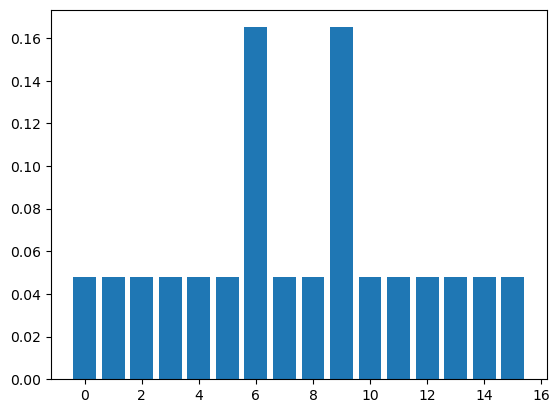

In [13]:
m = 2; N = 4;
Nt = int(np.ceil(np.pi/4 * np.sqrt(N/m)));
print("Optimal # of iterations: ",k);

Puzz_qr = QuantumRegister(size=4, name = "Puzz");
DGA_qr = AncillaRegister(size=4, name = "DGA");

Grover_qc = QuantumCircuit(Puzz_qr, DGA_qr, name = "Grover");

Grover_qc.compose(Initial_Circ, inplace=True);
for j in range(k):
    Grover_qc.compose(Oracle_Circ, inplace=True);
    Grover_qc.compose(Diff_Circ, inplace=True);

print(Grover_qc.draw())

Psi_Vec = Statevector(Grover_qc);
Sig = partial_trace(Psi_Vec, [j for j in range(4,8)]);

plt.bar(range(2**N), Sig.probabilities())